In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
from scipy.signal import find_peaks
from scipy.signal import peak_widths

run_number = 3

# Filter out the light-adapted strips

In [2]:

# output\trial_1\081624_rois_metadata_bignine.csv
metadata_all = pd.read_csv("./output/trial_1/081624_rois_metadata_bignine.csv")

metadata = metadata_all.copy()

# remove the light adapted strips. 
# 1. lower case the filename
metadata['filename'] = metadata['filename'].str.lower()
print(f"Before filtering out light-adapted images there are {len(metadata['filename'])} strips in the metadata.\n")

# 2. remove rows that don't contain 'dark'
metadata = metadata[metadata['filename'].str.contains('dark')]
print(f"After filtering, there are {len(metadata['filename'])} remaining.\n")

# get the strip numbers of the dark adapted strips
strip_filenames = metadata['strip_filename'].unique()

print(f"These are the remaining strips:")
for strip in metadata['strip_filename'].unique():
    print(f"\t{strip}")
    
# get the strips that were filtered out by comparing the strip_filenames in the metadata_all with the strip_numbers
filtered_out = metadata_all[~metadata_all['strip_filename'].isin(strip_filenames)]

print(f"These are the strips that were filtered out:")
for strip in filtered_out['strip_filename'].unique():
    print(f"\t{strip}")
    
    
# create a list of the isolated numbers from the strip filenames
strip_numbers = [int(strip.strip(".png").split('_')[-1]) for strip in strip_filenames]
print(f"\nThese are the strip numbers of the remaining strips: {strip_numbers}")

Before filtering out light-adapted images there are 9 strips in the metadata.

After filtering, there are 8 remaining.

These are the remaining strips:
	strip_106.png
	strip_134.png
	strip_135.png
	strip_161.png
	strip_176.png
	strip_187.png
	strip_229.png
	strip_232.png
These are the strips that were filtered out:
	strip_101.png

These are the strip numbers of the remaining strips: [106, 134, 135, 161, 176, 187, 229, 232]


# Filter the lumen df to only include the dark-adapted strips.

In [3]:
# load the lumen datafile with pd
lumen_data = pd.read_csv(f"./output/trial_1/csv/lumen_{run_number}.csv")

# print the length of the df 
print(f"Before filtering out the light-adapted strips, there are {len(lumen_data)} rows in the lumen data.\n")

# get the lumen data for the strips that were not filtered out
lumen_data = lumen_data[lumen_data['strip'].isin(strip_numbers)]

print(f"After filtering, there are {len(lumen_data)} remaining.\n")

Before filtering out the light-adapted strips, there are 10023 rows in the lumen data.

After filtering, there are 9081 remaining.



# get the threshold metadata so we can reference it

In [4]:
th_metadata = pd.read_csv(f"./output/trial_1/threshold_metadata_{run_number}.csv", index_col=0)
th_metadata["process"] = th_metadata.index
print(th_metadata.head())

                    method  morph_key  equalize  blur  thresh  maxval  \
99_otsuOffset   otsuOffset  closeOpen      True  True      90     255   
100_otsuOffset  otsuOffset  closeOpen      True  True      90     255   
101_otsuOffset  otsuOffset  closeOpen      True  True      90     255   
102_otsuOffset  otsuOffset  closeOpen      True  True      90     255   
103_otsuOffset  otsuOffset  closeOpen      True  True      90     255   

                blocksize  c  \
99_otsuOffset          25  2   
100_otsuOffset         25  2   
101_otsuOffset         25  2   
102_otsuOffset         25  2   
103_otsuOffset         25  2   

                                                       morph_args  offset  \
99_otsuOffset   {'name': 'closeOpen', 'closing_kernel': array(...   1.000   
100_otsuOffset  {'name': 'closeOpen', 'closing_kernel': array(...   1.025   
101_otsuOffset  {'name': 'closeOpen', 'closing_kernel': array(...   1.050   
102_otsuOffset  {'name': 'closeOpen', 'closing_kernel': arra

# calculate the mean width of the lumen, grouped by the process

165
process
100_otsuOffset    5.906844
101_otsuOffset    5.750272
102_otsuOffset    5.563348
103_otsuOffset    5.422333
104_otsuOffset    5.251879
Name: lumen_width_nm, dtype: float64


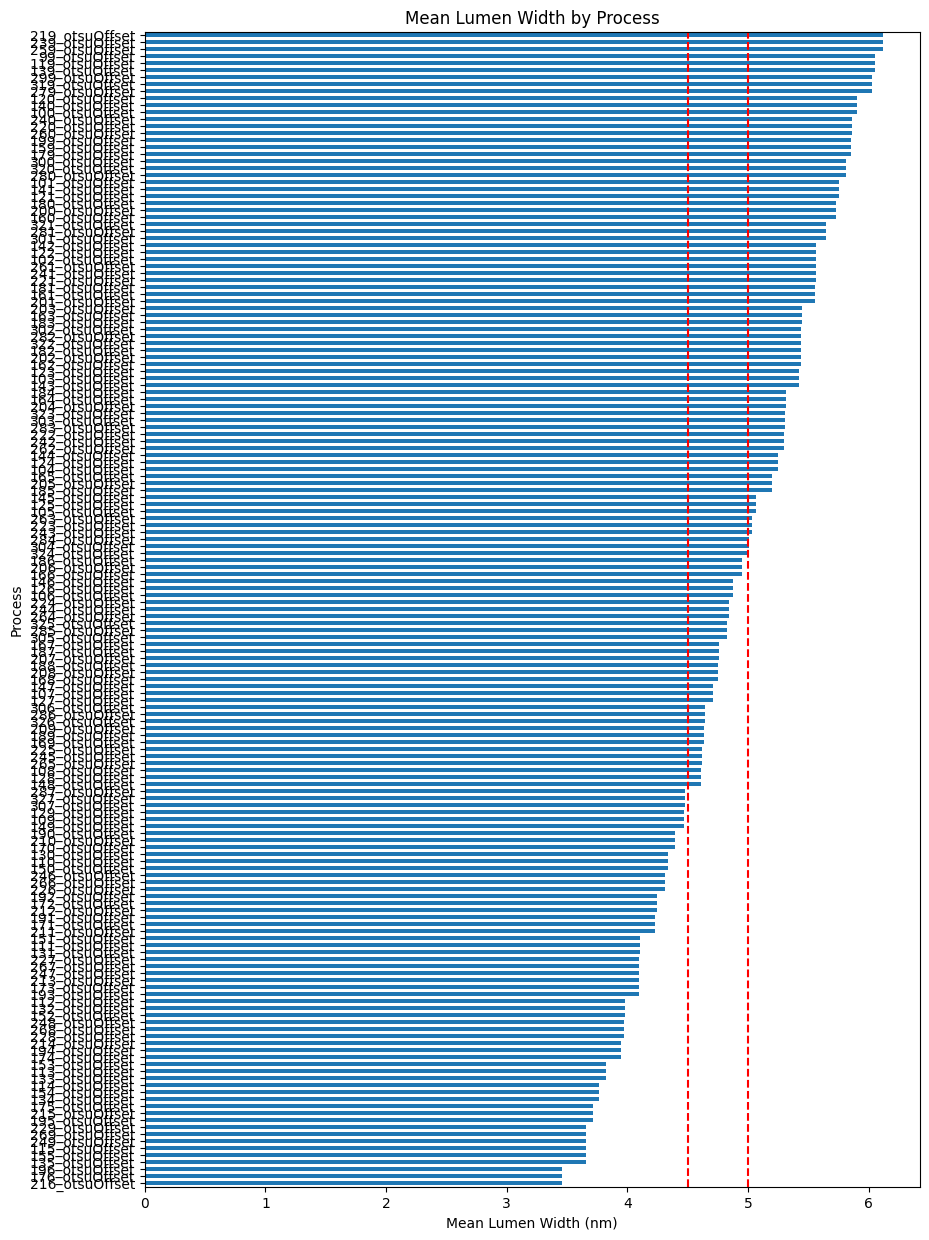

In [5]:

# we need to get the mean width of the lumen for each image, but grouped by process. this is a groupby operation
mean_widths = lumen_data.groupby('process')['lumen_width_nm'].mean()

print(len(mean_widths))
print(mean_widths.head())

# sort the mean widths
mean_widths = mean_widths.sort_values()
expected_range = [4.5, 5]

# plot the mean widths. figsize the first number is the width, the second is the height
plt.figure(figsize=(10, 15))
mean_widths.plot(kind='barh')
plt.xlabel('Mean Lumen Width (nm)')
plt.ylabel('Process')
plt.title('Mean Lumen Width by Process')

# mark a dashed vertical line at the low and high end of the expected range
plt.axvline(expected_range[0], color='r', linestyle='--')
plt.axvline(expected_range[1], color='r', linestyle='--')

plt.show()

# Take a closer look at those in the range

In [6]:
# print the processes in mean_width that are within the range +/- 0.5 nm
# adjusted_range = [expected_range[0] - 0.5, expected_range[1] + 0.5]
adjusted_range = [expected_range[0], expected_range[1]]

adj_mean_widths = mean_widths[mean_widths.between(adjusted_range[0], adjusted_range[1])]
print(adj_mean_widths)
print(type(adj_mean_widths))

process
148_otsuOffset    4.611623
128_otsuOffset    4.611623
108_otsuOffset    4.611623
265_otsuOffset    4.614807
245_otsuOffset    4.614807
225_otsuOffset    4.614807
169_otsuOffset    4.637804
189_otsuOffset    4.637804
209_otsuOffset    4.637804
326_otsuOffset    4.639299
286_otsuOffset    4.639299
306_otsuOffset    4.639299
127_otsuOffset    4.709836
107_otsuOffset    4.709836
147_otsuOffset    4.709836
168_otsuOffset    4.751719
208_otsuOffset    4.751719
188_otsuOffset    4.751719
207_otsuOffset    4.758904
187_otsuOffset    4.758904
167_otsuOffset    4.758904
305_otsuOffset    4.823881
285_otsuOffset    4.823881
325_otsuOffset    4.823881
264_otsuOffset    4.838167
244_otsuOffset    4.838167
224_otsuOffset    4.838167
106_otsuOffset    4.871001
126_otsuOffset    4.871001
146_otsuOffset    4.871001
166_otsuOffset    4.947262
206_otsuOffset    4.947262
186_otsuOffset    4.947262
Name: lumen_width_nm, dtype: float64
<class 'pandas.core.series.Series'>


In [7]:
# get the index for the processes that are within the range
adj_processes = adj_mean_widths.index
print(adj_processes)

Index(['148_otsuOffset', '128_otsuOffset', '108_otsuOffset', '265_otsuOffset',
       '245_otsuOffset', '225_otsuOffset', '169_otsuOffset', '189_otsuOffset',
       '209_otsuOffset', '326_otsuOffset', '286_otsuOffset', '306_otsuOffset',
       '127_otsuOffset', '107_otsuOffset', '147_otsuOffset', '168_otsuOffset',
       '208_otsuOffset', '188_otsuOffset', '207_otsuOffset', '187_otsuOffset',
       '167_otsuOffset', '305_otsuOffset', '285_otsuOffset', '325_otsuOffset',
       '264_otsuOffset', '244_otsuOffset', '224_otsuOffset', '106_otsuOffset',
       '126_otsuOffset', '146_otsuOffset', '166_otsuOffset', '206_otsuOffset',
       '186_otsuOffset'],
      dtype='object', name='process')


In [8]:
# take the index of the th_metadata and create a column
th_metadata['in_range'] = th_metadata.index.isin(adj_processes)
print(len(th_metadata))

# filter the th_metadata to only include the processes that are in the range
df = th_metadata[th_metadata['in_range']].copy()
print(len(df))

240
33


# The best results

In [9]:
# merge the series into the df, joining on the process column
df = df.merge(adj_mean_widths, left_on='process', right_index=True)
df

,method,morph_key,equalize,blur,thresh,maxval,blocksize,c,morph_args,offset,key,process,in_range,lumen_width_nm
106_otsuOffset,otsuOffset,closeOpen,True,True,90,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.175,106_otsuOffset,106_otsuOffset,True,4.871001
107_otsuOffset,otsuOffset,closeOpen,True,True,90,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.200,107_otsuOffset,107_otsuOffset,True,4.709836
108_otsuOffset,otsuOffset,closeOpen,True,True,90,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.225,108_otsuOffset,108_otsuOffset,True,4.611623
126_otsuOffset,otsuOffset,closeOpen,True,True,100,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.175,126_otsuOffset,126_otsuOffset,True,4.871001
127_otsuOffset,otsuOffset,closeOpen,True,True,100,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.200,127_otsuOffset,127_otsuOffset,True,4.709836
128_otsuOffset,otsuOffset,closeOpen,True,True,100,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.225,128_otsuOffset,128_otsuOffset,True,4.611623
146_otsuOffset,otsuOffset,closeOpen,True,True,130,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.175,146_otsuOffset,146_otsuOffset,True,4.871001
147_otsuOffset,otsuOffset,closeOpen,True,True,130,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.200,147_otsuOffset,147_otsuOffset,True,4.709836
148_otsuOffset,otsuOffset,closeOpen,True,True,130,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.225,148_otsuOffset,148_otsuOffset,True,4.611623
166_otsuOffset,otsuOffset,closeOpen,True,False,90,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.175,166_otsuOffset,166_otsuOffset,True,4.947262


In [10]:
import os
import shutil
import glob

# Isolate the data that has blurring and equalization, and has an offset within 1.2 and 1.17
df = df[(df['blur'] == True) & (df['equalize'] == True) & (df['offset'].between(1.17, 1.2))]

print(len(df))

# print out the process names in a list:
for process in df['process']:
    print(process)
    
    


6
106_otsuOffset
107_otsuOffset
126_otsuOffset
127_otsuOffset
146_otsuOffset
147_otsuOffset


In [11]:
for process in df['process']:
    src = os.path.join("./output/trial_1/processed_images", process)
    dst = os.path.join("./output/trial_1/poi", process)
    os.makedirs(dst, exist_ok=True)
    print(f"Copying {src} to {dst}")
    shutil.copytree(src, dst, dirs_exist_ok=True)
    
    # Copy the masks as well
    masks_src = os.path.join("./output/trial_1/masks", process, "*.png")
    masks_dst = os.path.join(dst, "masks")
    os.makedirs(masks_dst, exist_ok=True)
    for mask in glob.glob(masks_src):
        shutil.copy2(mask, masks_dst)
        
# copy the metadata to the poi folder
shutil.copy2("./output/trial_1/081624_rois_metadata_bignine.csv", "./output/trial_1/poi/081624_rois_metadata_bignine.csv")

# copy over the roi_images in our metadata to the poi folder, under roi_images

Copying ./output/trial_1/processed_images\106_otsuOffset to ./output/trial_1/poi\106_otsuOffset
Copying ./output/trial_1/processed_images\107_otsuOffset to ./output/trial_1/poi\107_otsuOffset
Copying ./output/trial_1/processed_images\126_otsuOffset to ./output/trial_1/poi\126_otsuOffset
Copying ./output/trial_1/processed_images\127_otsuOffset to ./output/trial_1/poi\127_otsuOffset
Copying ./output/trial_1/processed_images\146_otsuOffset to ./output/trial_1/poi\146_otsuOffset
Copying ./output/trial_1/processed_images\147_otsuOffset to ./output/trial_1/poi\147_otsuOffset


'./output/trial_1/poi/081624_rois_metadata_bignine.csv'

In [12]:
# Initialize an empty list to store the summary lines
summary_lines = []

# For each process, print out the lumen width for each strip and the overall mean lumen width
for process in df['process']:
    summary_lines.append(f"Process {process}:")
    
    process_df = lumen_data[lumen_data['process'] == process]
    
    # Initialize a list to store the mean lumen widths for each strip
    strip_mean_lumen_widths = []
    
    for strip in process_df['strip'].unique():
        strip_df = process_df[process_df['strip'] == strip]
        mean_lumen_width = strip_df['lumen_width_nm'].mean()
        strip_mean_lumen_widths.append(mean_lumen_width)
        summary_lines.append(f"  Strip {strip}: Mean lumen width: {mean_lumen_width:.2f} nm")
    
    # Calculate the overall mean lumen width for the process
    overall_mean_lumen_width = sum(strip_mean_lumen_widths) / len(strip_mean_lumen_widths)
    summary_lines.append(f"  Overall mean lumen width: {overall_mean_lumen_width:.2f} nm")
    summary_lines.append("\n")

# Join the summary lines into a single string
summary = "\n".join(summary_lines)

# Print the summary (or you can use it in an email)
print(summary)

Process 106_otsuOffset:
  Strip 106: Mean lumen width: 4.93 nm
  Strip 134: Mean lumen width: 4.25 nm
  Strip 135: Mean lumen width: 4.36 nm
  Strip 161: Mean lumen width: 4.19 nm
  Strip 176: Mean lumen width: 4.82 nm
  Strip 187: Mean lumen width: 5.17 nm
  Strip 229: Mean lumen width: 4.87 nm
  Strip 232: Mean lumen width: 5.64 nm
  Overall mean lumen width: 4.78 nm


Process 107_otsuOffset:
  Strip 106: Mean lumen width: 4.76 nm
  Strip 134: Mean lumen width: 4.06 nm
  Strip 135: Mean lumen width: 4.24 nm
  Strip 161: Mean lumen width: 4.02 nm
  Strip 176: Mean lumen width: 4.70 nm
  Strip 187: Mean lumen width: 5.02 nm
  Strip 229: Mean lumen width: 4.72 nm
  Strip 232: Mean lumen width: 5.54 nm
  Overall mean lumen width: 4.63 nm


Process 126_otsuOffset:
  Strip 106: Mean lumen width: 4.93 nm
  Strip 134: Mean lumen width: 4.25 nm
  Strip 135: Mean lumen width: 4.36 nm
  Strip 161: Mean lumen width: 4.19 nm
  Strip 176: Mean lumen width: 4.82 nm
  Strip 187: Mean lumen width: 5.

In [13]:
import pandas as pd

# Initialize an empty list to store the summary data
summary_data = []

# For each process, collect the lumen width for each strip and the overall mean lumen width
for process in df['process']:
    process_df = lumen_data[lumen_data['process'] == process]
    
    # Initialize a list to store the mean lumen widths for each strip
    strip_mean_lumen_widths = []
    
    for strip in process_df['strip'].unique():
        strip_df = process_df[process_df['strip'] == strip]
        mean_lumen_width = strip_df['lumen_width_nm'].mean()
        strip_mean_lumen_widths.append(mean_lumen_width)
        summary_data.append([process, strip, mean_lumen_width])
    
    # Calculate the overall mean lumen width for the process
    overall_mean_lumen_width = sum(strip_mean_lumen_widths) / len(strip_mean_lumen_widths)
    summary_data.append([process, 'Overall', overall_mean_lumen_width])

# Create a DataFrame from the summary data
summary_df = pd.DataFrame(summary_data, columns=['Process', 'Strip', 'Mean Lumen Width (nm)'])

# Save the DataFrame to a CSV file
summary_df.to_csv('lumen_width_summary.csv', index=False)

# Print the DataFrame (optional)
print(summary_df)

           Process    Strip  Mean Lumen Width (nm)
0   106_otsuOffset      106               4.925780
1   106_otsuOffset      134               4.251912
2   106_otsuOffset      135               4.358844
3   106_otsuOffset      161               4.188437
4   106_otsuOffset      176               4.818865
5   106_otsuOffset      187               5.171237
6   106_otsuOffset      229               4.870395
7   106_otsuOffset      232               5.636265
8   106_otsuOffset  Overall               4.777717
9   107_otsuOffset      106               4.756129
10  107_otsuOffset      134               4.062932
11  107_otsuOffset      135               4.237567
12  107_otsuOffset      161               4.017216
13  107_otsuOffset      176               4.695376
14  107_otsuOffset      187               5.021790
15  107_otsuOffset      229               4.717101
16  107_otsuOffset      232               5.538405
17  107_otsuOffset  Overall               4.630815
18  126_otsuOffset      106    

# Lets provide some visual feedback, showing the contours of the membranes on the original roi images.

In [14]:

def getMembraneImage(process_folder: str, strip_name: str) -> np.ndarray:
    """
    Get the membrane image for a given process.
    
    Args:
        process_folder: The folder of the process (e.g., ./output/trial_1/processed_images/process_1).
        strip_name: The name of the strip image file (e.g., 'strip_101.png').
    
    Returns:
        The membrane image as a NumPy array.
    """
    # Get the path to the membrane image
    membrane_image_path = os.path.join(process_folder, 'membrane', strip_name)
    
    # Load the membrane image
    membrane_image = cv2.imread(membrane_image_path, cv2.IMREAD_GRAYSCALE)
    
    return membrane_image

def getRawImage(roi_folder: str, strip_name: str) -> np.ndarray:
    """
    Get the raw image for a given strip.
    
    Args:
        strip_name: The name of the strip.
    
    Returns:
        The raw image as a NumPy array, converted to RGB.
        
    """
    # Get the path to the raw image
    raw_image_path = os.path.join(roi_folder, strip_name)
    
    # Load the raw image
    raw_image = cv2.imread(raw_image_path, cv2.IMREAD_GRAYSCALE)
    
    # convert to a rgb image
    raw_image = cv2.cvtColor(raw_image, cv2.COLOR_GRAY2RGB)
    
    return raw_image


In [15]:
# look at the images in the poi folder
# D:\repos\gapfinder_images\output\trial_1\poi\106_otsuOffset\membrane\strip_101.png

# get the contents of the poi folder, but only the folder names
poi_folder = "./output/trial_1/poi"
roi_folder = "./output/trial_1/rois"

process_folders = [f.path for f in os.scandir(poi_folder) if f.is_dir()]

# get the strip filenames from the metadata bignine
metadata = pd.read_csv("./output/trial_1/081624_rois_metadata_bignine.csv")
strip_filenames = metadata['strip_filename'].unique()

# create a dict of the roi_images and their filenames
roi_images = {}

for strip in strip_filenames:
    roi_images[strip] = getRawImage(roi_folder, strip)
    
print(len(roi_images))
for key in roi_images.keys():
    print(key)

9
strip_101.png
strip_106.png
strip_134.png
strip_135.png
strip_161.png
strip_176.png
strip_187.png
strip_229.png
strip_232.png


# Produce images that show the contours on the raw images
for each of the processes, we will get the membrane image, get the contours, and then draw the contours on top of the original image.
Then save that image in the process folder, in the subfolder "contours". The filename will be the strip filename.

./output/trial_1/poi\106_otsuOffset
(120, 60)
(120, 60, 3)
(120, 60, 3)


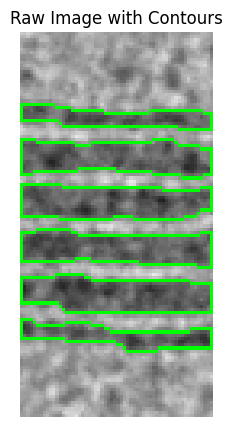

In [16]:
def drawContours(membrane_image, raw_image: np.ndarray, color: tuple = (0, 255, 0), thickness: int = 1) -> np.ndarray:
    """
    Draw the contours of the membrane on the raw image.
    
    Args:
        membrane_image: The membrane image as a NumPy array.
        raw_image: The raw image as a NumPy array.
        color: The color of the contours.
    
    Returns:
        The raw image with the contours drawn on it.
    """
    # inv the membrane image so that the contours work properly
    _, inv_membrane_image = cv2.threshold(membrane_image, 127, 255, cv2.THRESH_BINARY_INV)

    # Find the contours in the membrane image
    contours, _ = cv2.findContours(inv_membrane_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw the contours on the raw image (-1 means all contours)
    raw_image_with_contours = cv2.drawContours(raw_image.copy(), contours, -1, color, thickness)
    
    return raw_image_with_contours

# Get the membrane image for the first process and strip
#first process in process_folders
process = process_folders[0]

strip = strip_filenames[0]

print(process)
membrane_image = getMembraneImage(process, strip)
print(membrane_image.shape)

# Get the raw image for the strip
raw_image = getRawImage(roi_folder, strip)
print(raw_image.shape)

# Draw the contours of the membrane on the raw image
raw_image_with_contours = drawContours(membrane_image, raw_image, color=(0, 255, 0), thickness=1)

print(raw_image_with_contours.shape)
# Display the raw image with contours
plt.figure(figsize=(5, 5))
plt.imshow(raw_image_with_contours)
plt.axis('off')
plt.title('Raw Image with Contours')
plt.show()

# now do that for each process folder, for each strip name

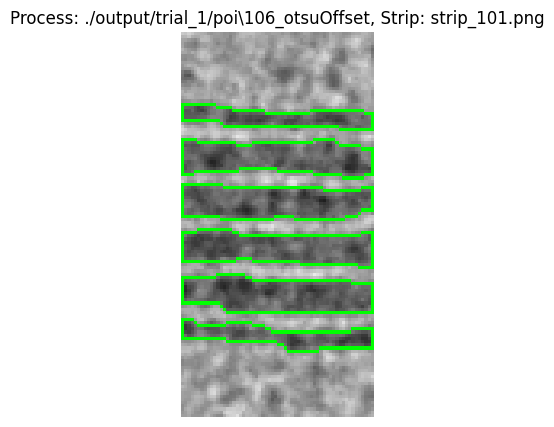

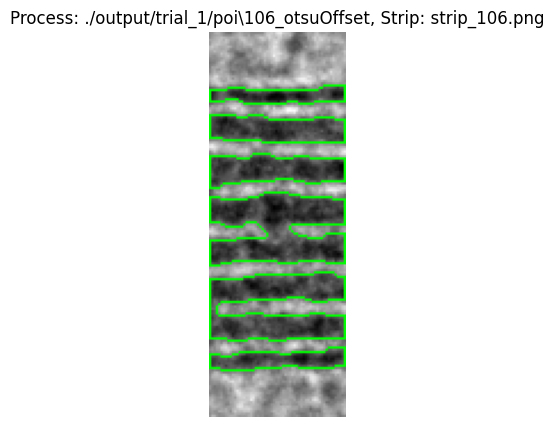

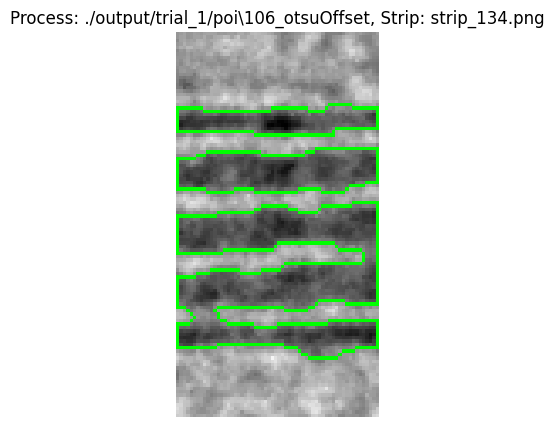

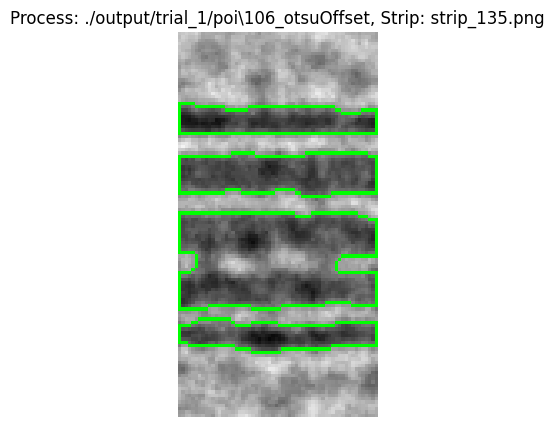

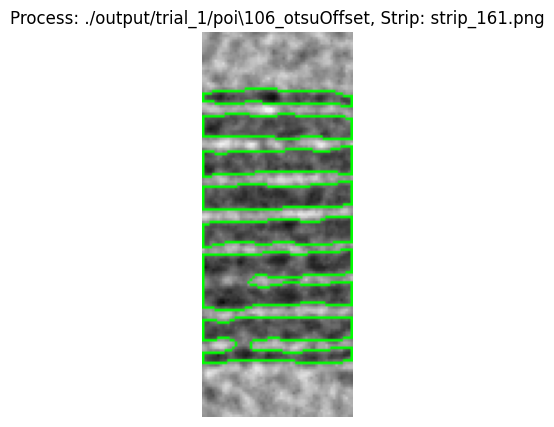

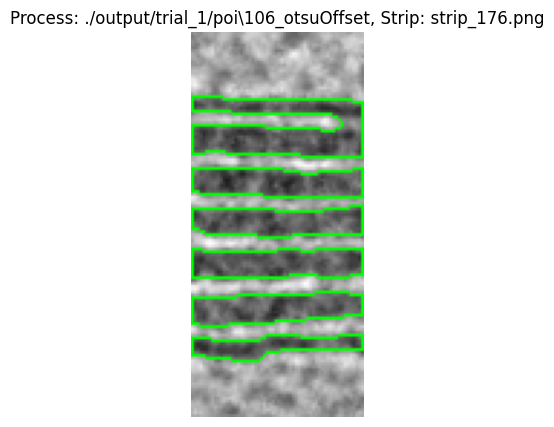

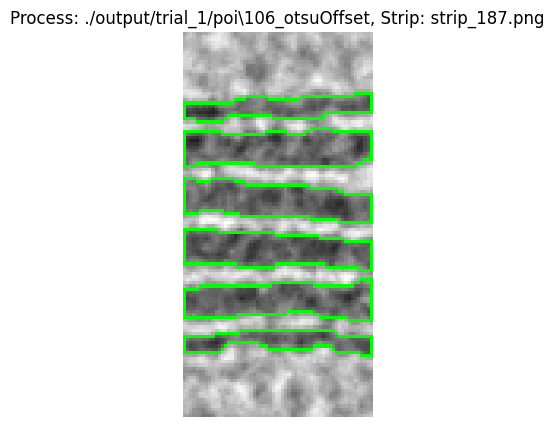

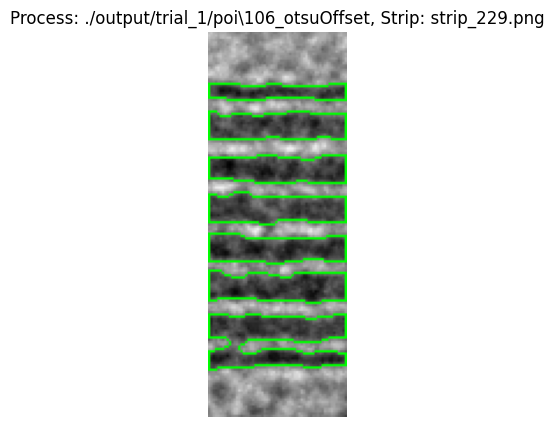

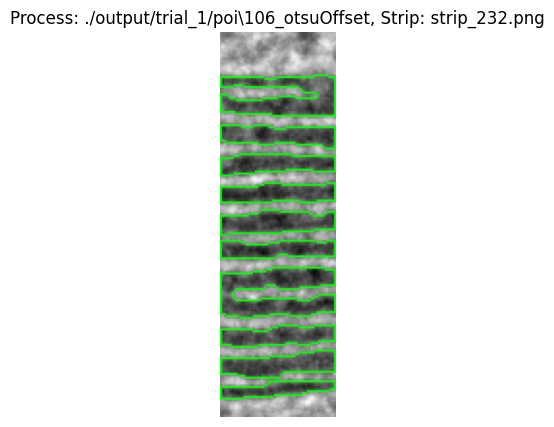

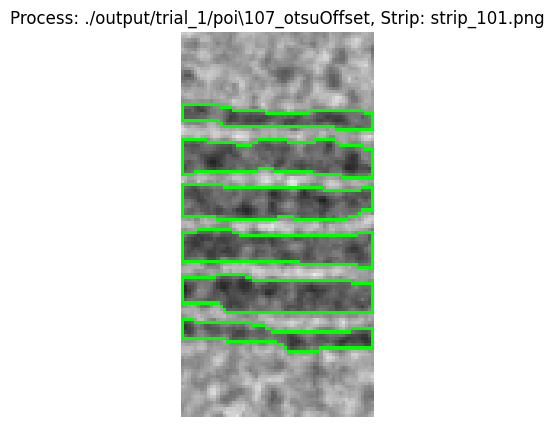

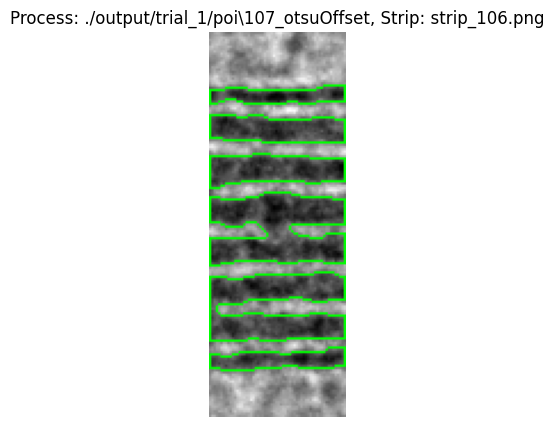

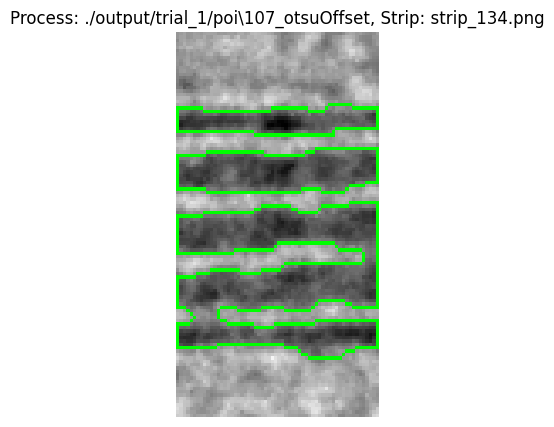

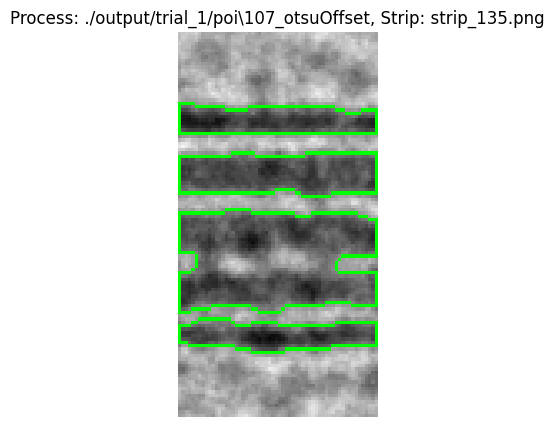

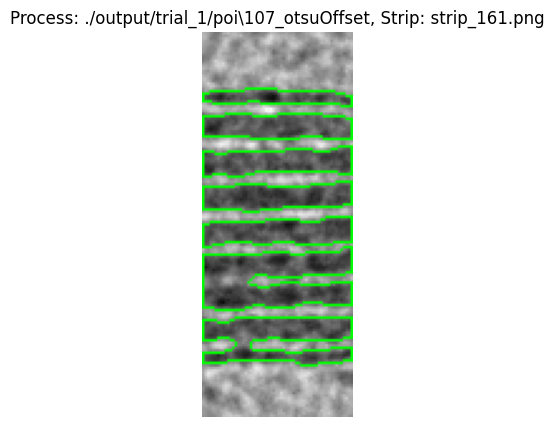

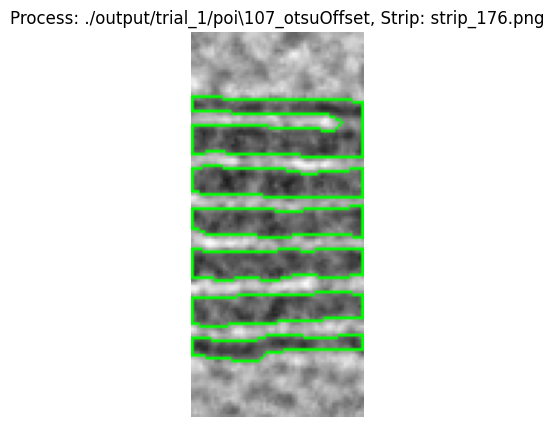

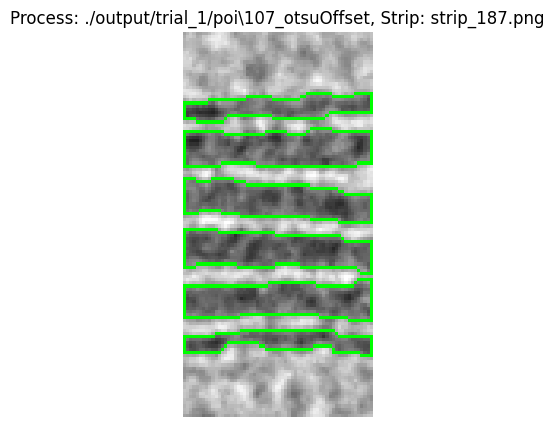

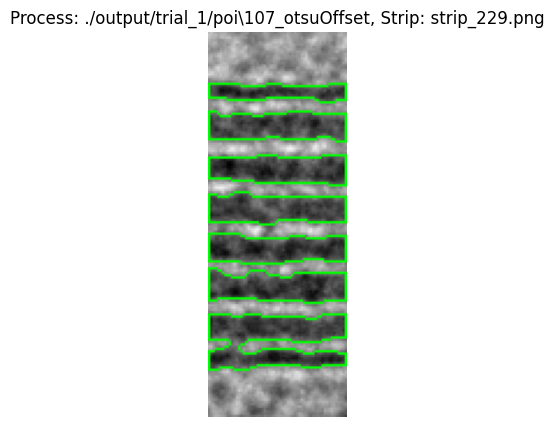

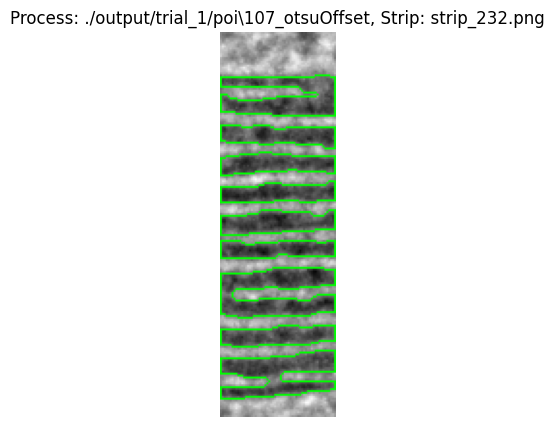

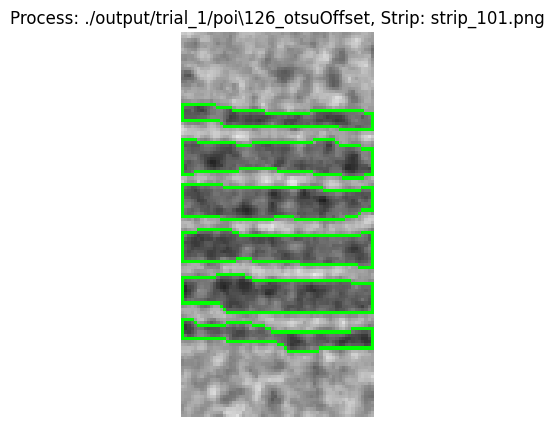

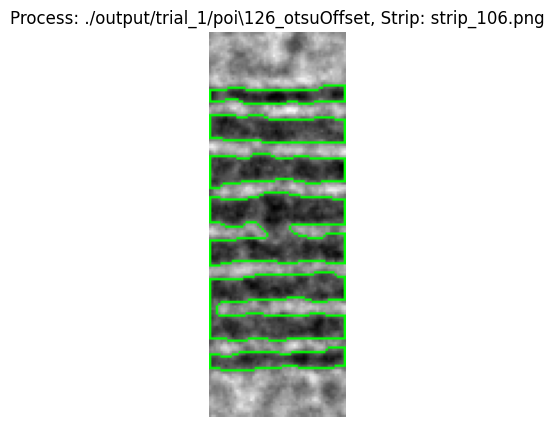

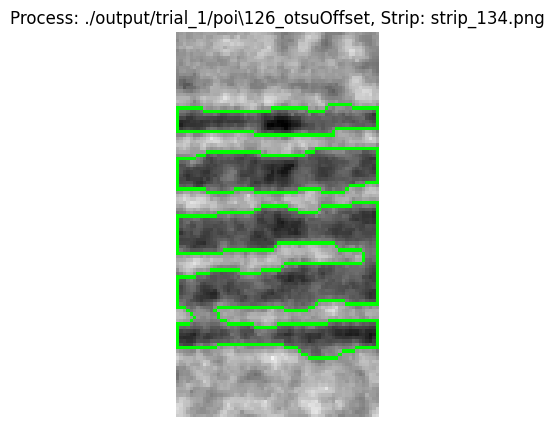

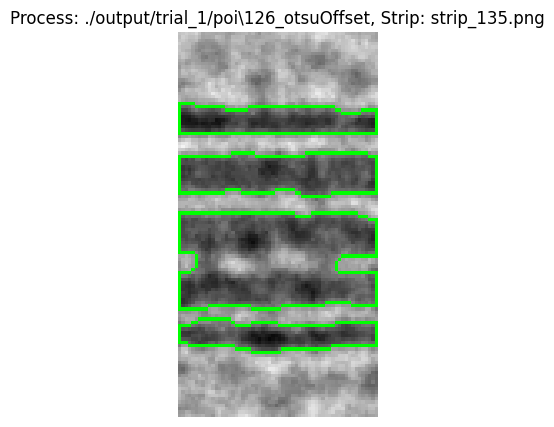

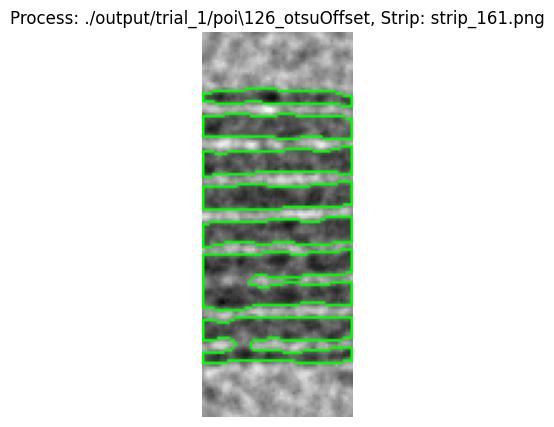

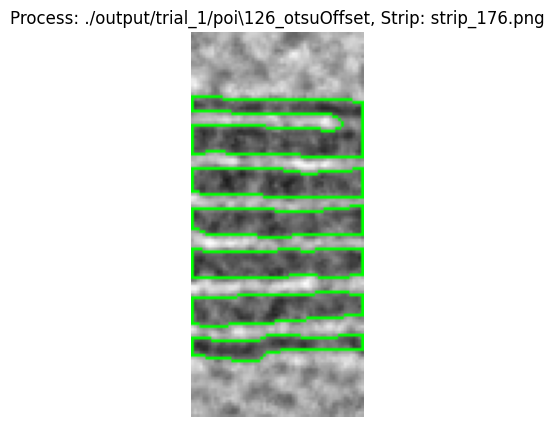

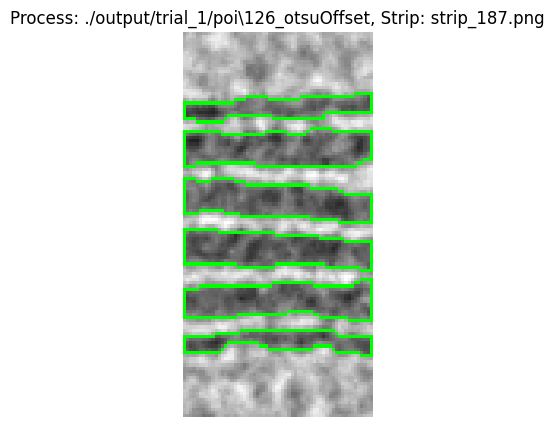

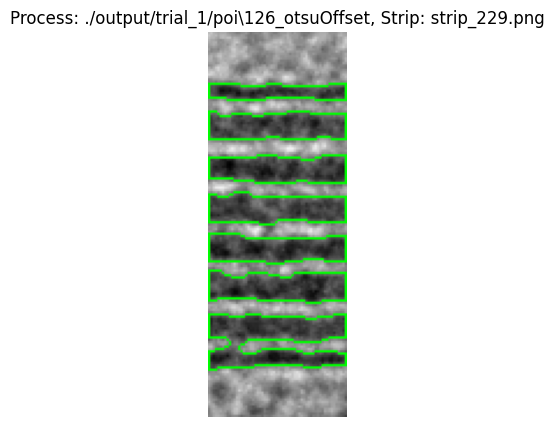

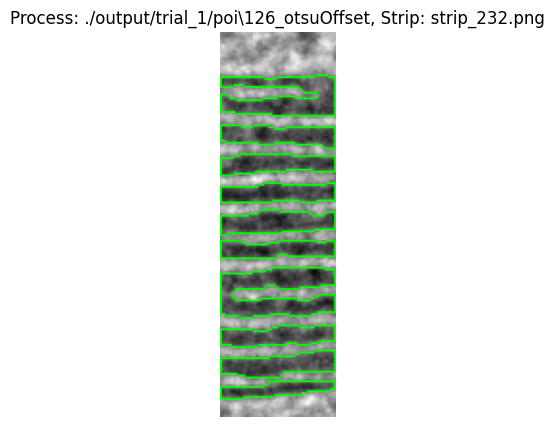

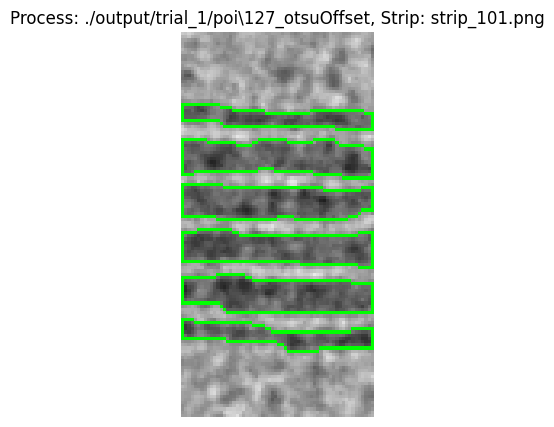

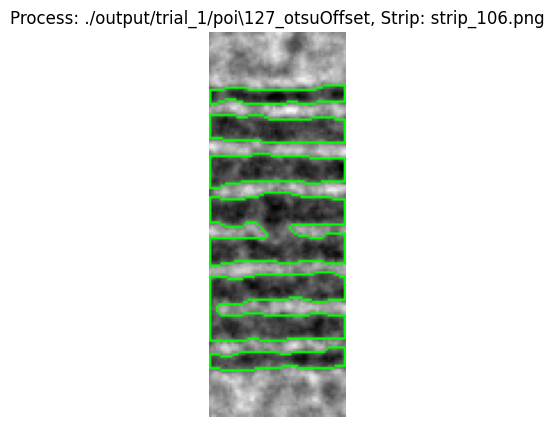

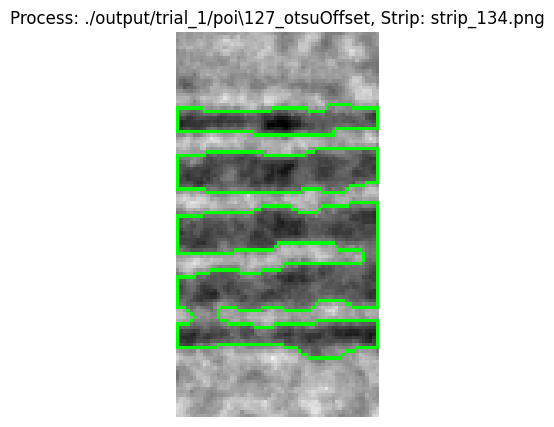

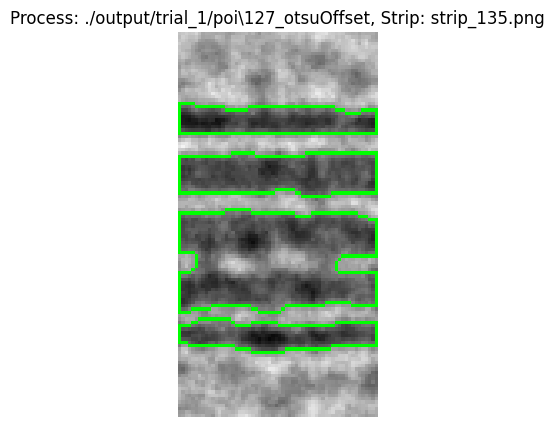

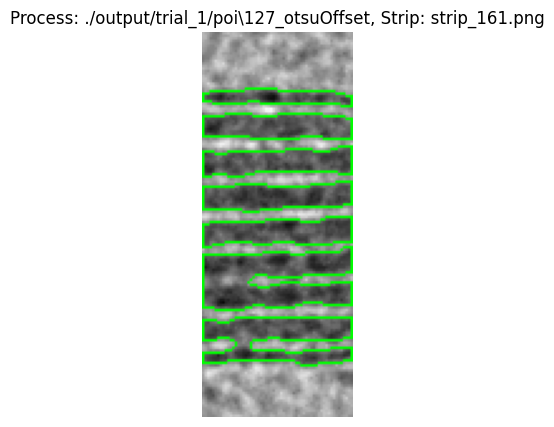

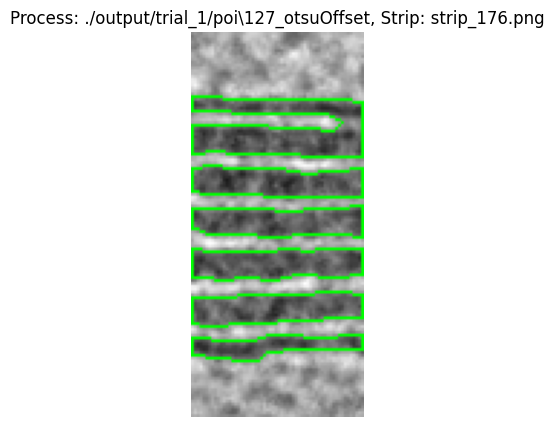

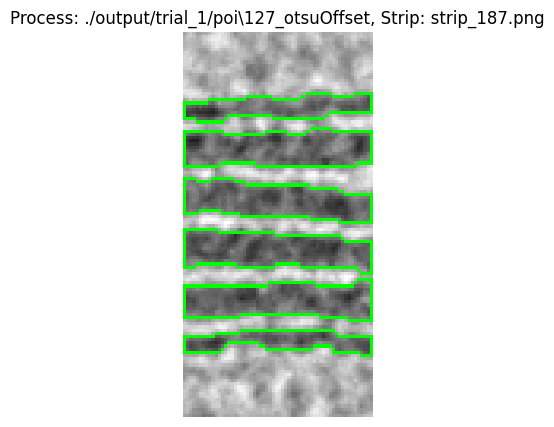

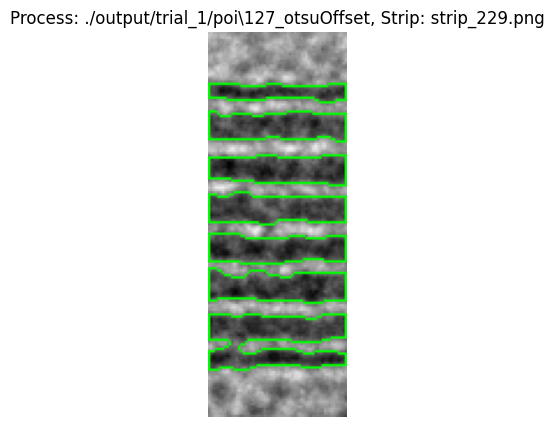

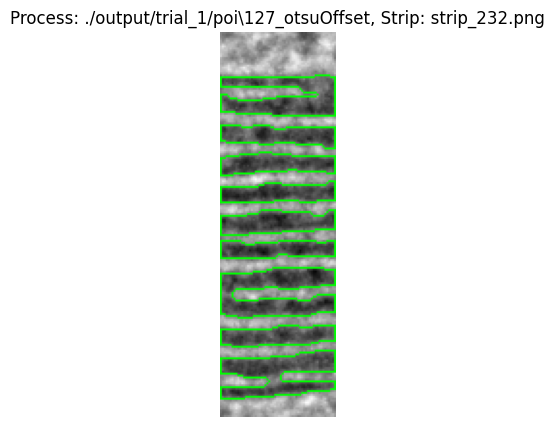

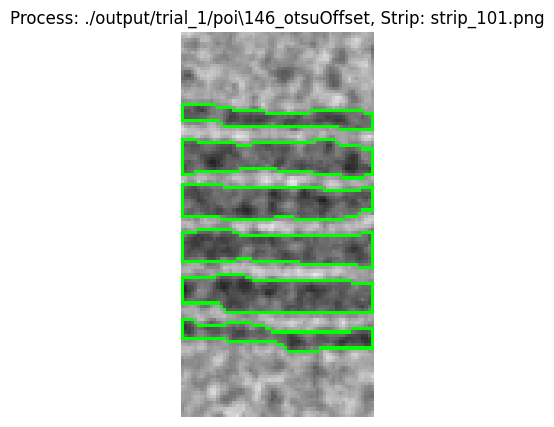

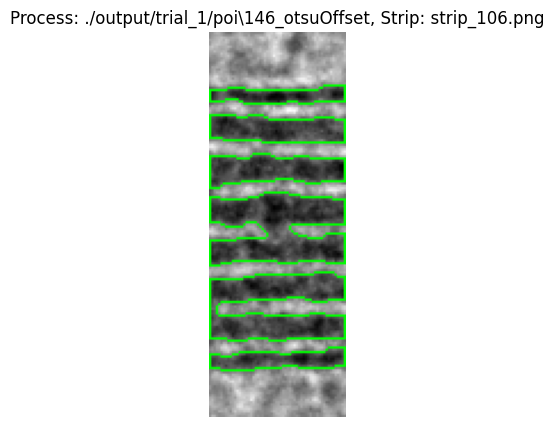

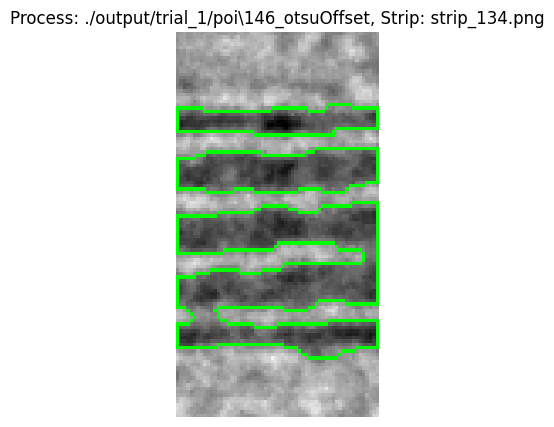

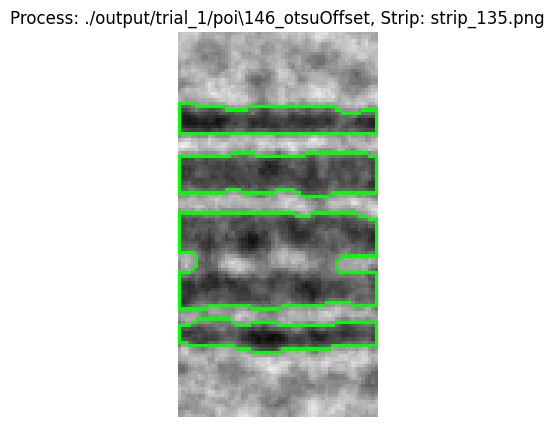

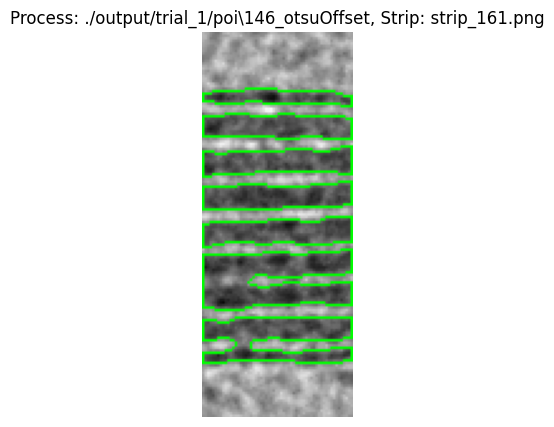

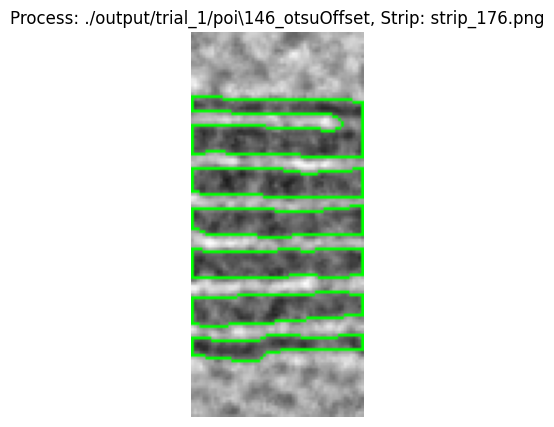

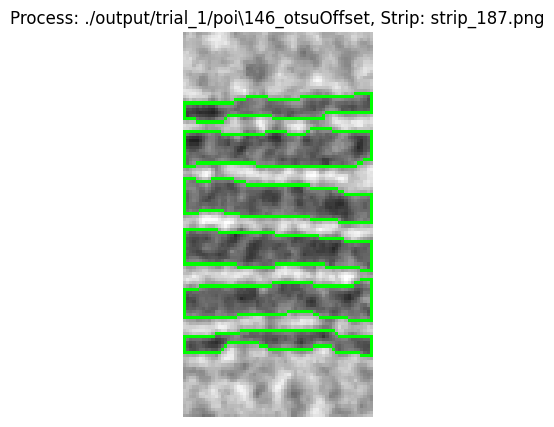

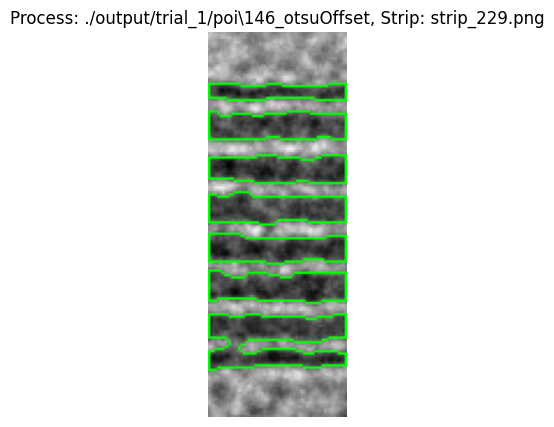

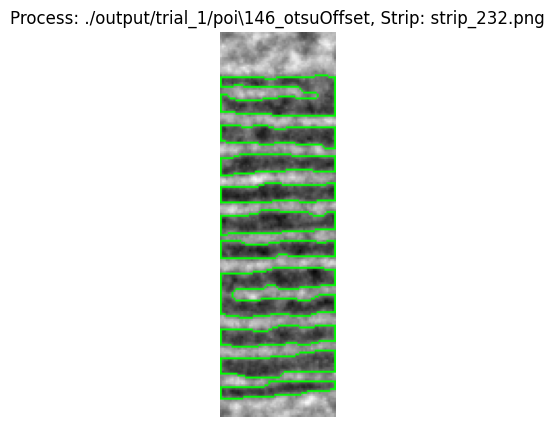

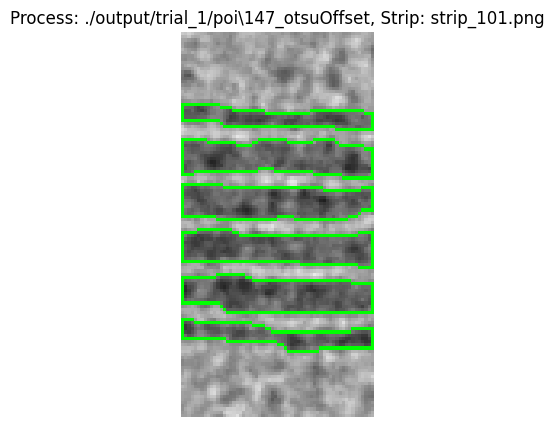

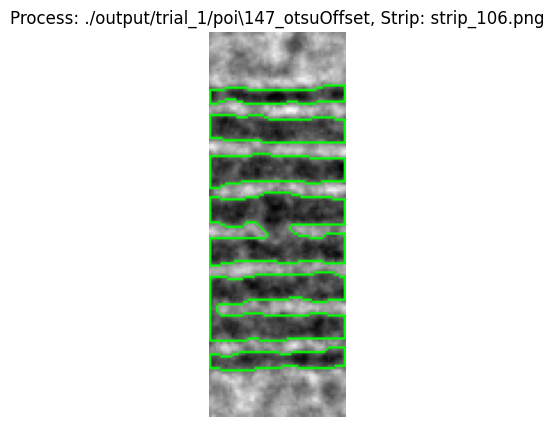

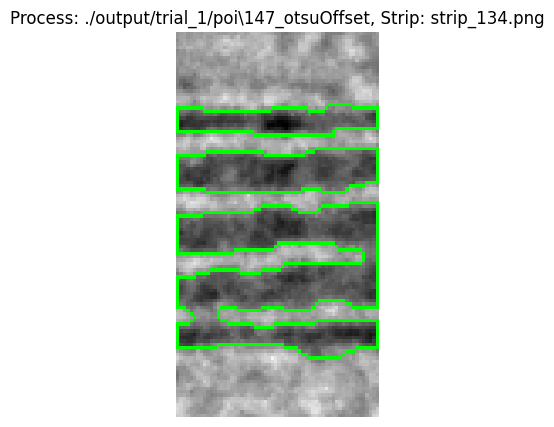

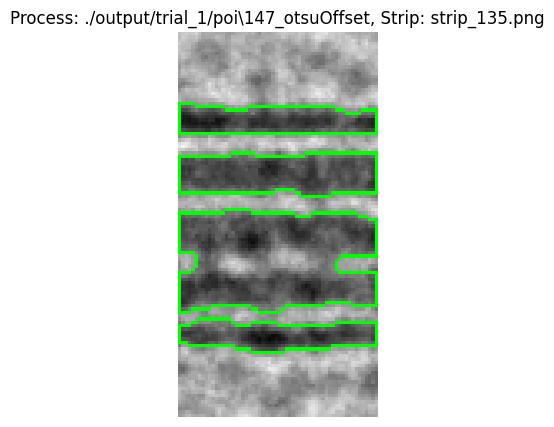

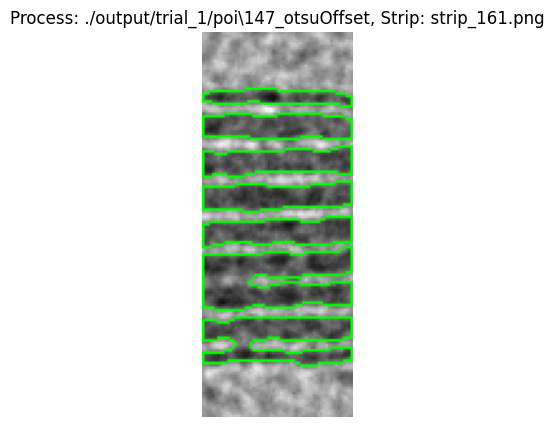

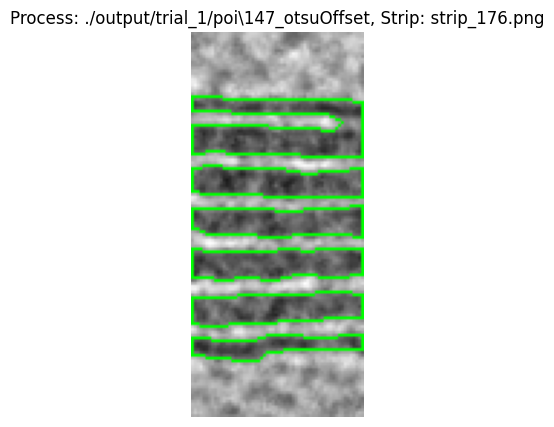

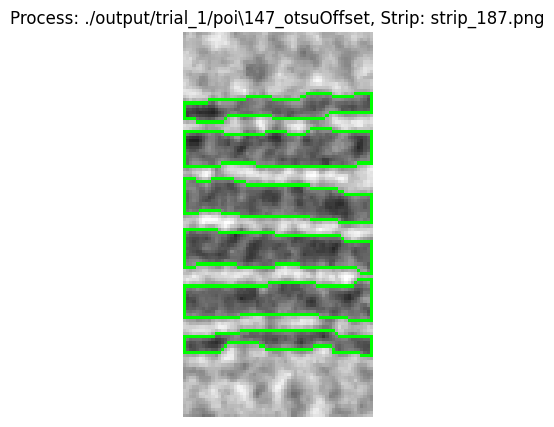

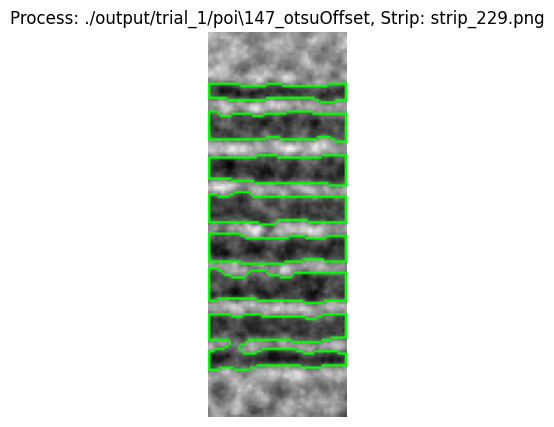

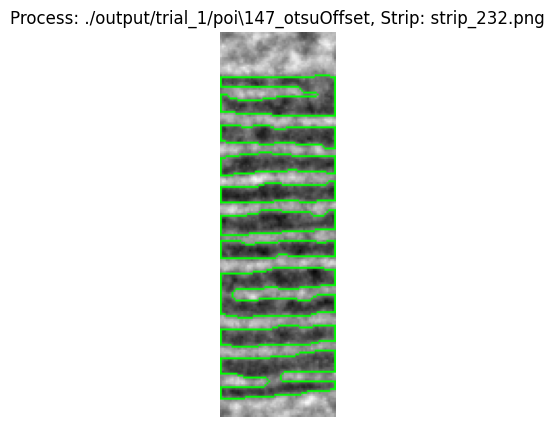

In [17]:
from itertools import product

combinations = list(product(process_folders, strip_filenames))

for process, strip in combinations:
    membrane_image = getMembraneImage(process, strip)
    raw_image = getRawImage(roi_folder, strip)
    raw_image_with_contours = drawContours(membrane_image, raw_image, color=(0, 255, 0), thickness=1)
    
    # use opencv to write the image to the process_folder/contours folder
    contours_folder = os.path.join(process, 'contours')

    os.makedirs(contours_folder, exist_ok=True)
        
    contours_image_path = os.path.join(contours_folder, strip)

    cv2.imwrite(contours_image_path, raw_image_with_contours) 
    
    plt.figure(figsize=(5, 5))
    plt.imshow(raw_image_with_contours)
    plt.axis('off')
    plt.title(f'Process: {process}, Strip: {strip}')
    plt.show()

# # Get the membrane image for the first process and strip
# #first process in process_folders
# process = process_folders[0]

# strip = strip_filenames[0]

# print(process)
# membrane_image = getMembraneImage(process, strip)
# print(membrane_image.shape)

# # Get the raw image for the strip
# raw_image = getRawImage(roi_folder, strip)
# print(raw_image.shape)

# # Draw the contours of the membrane on the raw image
# raw_image_with_contours = drawContours(membrane_image, raw_image, color=(0, 255, 0), thickness=1)

# print(raw_image_with_contours.shape)
# # Display the raw image with contours
# plt.figure(figsize=(5, 5))
# plt.imshow(raw_image_with_contours)
# plt.axis('off')
# plt.title('Raw Image with Contours')
# plt.show()